In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
%matplotlib inline

In [0]:
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Input, LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, InputLayer, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.callbacks.callbacks import Callback, EarlyStopping

In [11]:
train_data = pd.read_csv("/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/1fe720be-90e4-4e06-9b52-9de93e0ea937_train.csv")
test_data = pd.read_csv("/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/fcac6286-6db1-4577-ad80-612fb9d36db9_test.csv")
train_data.head()

,text,labels
0,@realDonaldTrump This is one of the worst time...,0
1,How about the crowd in Oval in today's #AUSvIN...,1
2,@skroskz @shossy2 @JoeBiden Biden &amp; his so...,0
3,#etsy shop: Benedict Donald so called presiden...,1
4,@realDonaldTrump Good build a wall around Arka...,0


In [12]:
train_data.shape, test_data.shape

((5266, 2), (1153, 3))

In [13]:
def clean_text(line):
    pat1 = r'@[A-Za-z0-9]+'
    pat2 = r'https?://[A-Za-z0-9./]+'
    combined_pat = r'|'.join((pat1, pat2))
    
    soup = BeautifulSoup(line, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    split = lower_case.split(" ")
    return " ".join(list(filter(None, split))).strip()

def get_indices(x): return np.argmax(x)

train_data["clean_text"] = train_data.text.apply(lambda x: clean_text(x))
train_data.head()

,text,labels,clean_text
0,@realDonaldTrump This is one of the worst time...,0,this is one of the worst times to be american ...
1,How about the crowd in Oval in today's #AUSvIN...,1,how about the crowd in oval in today s ausvind...
2,@skroskz @shossy2 @JoeBiden Biden &amp; his so...,0,biden his son hunter took advantage of their p...
3,#etsy shop: Benedict Donald so called presiden...,1,etsy shop benedict donald so called president ...
4,@realDonaldTrump Good build a wall around Arka...,0,good build a wall around arkansas fucktrump fu...


In [0]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
VALIDATION_SPLIT = 0.33
EMBEDDING_DIM = 200

EMBEDDING_PATH = "/gdrive/My Drive/Dataset/WordEmbeddings/glove.twitter.27B.200d.txt"

In [15]:
embeddings_index = {}
f = open(EMBEDDING_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [16]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_data["clean_text"])

sequences = tokenizer.texts_to_sequences(train_data["clean_text"])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train_data["labels"]))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]

x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 13623 unique tokens.
Shape of data tensor: (5266, 200)
Shape of label tensor: (5266, 2)


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Neural Models

## MLP

In [0]:
def mlp_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Flatten())

    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))

    print(model.summary())

    return model

In [19]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)

print("Model used : {}".format("MLP Only"))
mlp = mlp_model()

mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

mlp.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=100, 
          callbacks = [cbacks],
          batch_size=256)

loss, acc = mlp.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, mlp.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : MLP Only
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
dense_1 (Dense)              (None, 200, 100)          20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 200, 10)           1010      
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 10)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (No

[[328 357]
 [248 804]]


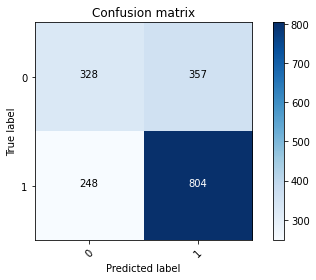

In [20]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 1D CNN

In [0]:
def one_dimensional_cnn():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(Conv1D(128, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(2, activation='softmax'))
    
    print(model.summary())
    
    return model

In [22]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)
epochs = 100
batch_size = 64

print("Model used : {}".format("CNN Only"))
cnn_model = one_dimensional_cnn()

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

cnn_model.fit(x_train, y_train, 
              validation_data=(x_val, y_val),
              epochs=epochs,
              callbacks = [cbacks],
              batch_size=batch_size)

loss, acc = cnn_model.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, cnn_model.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : CNN Only
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 197, 128)          102528    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 194, 128)          65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 128)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 97, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 128)           65664     
_________________________________________________________________
conv1d_4 (Conv1D)            (No

[[119 566]
 [ 65 987]]


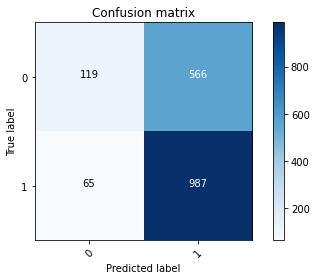

In [23]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## LSTM

In [0]:
def lstm_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(30, activation="relu", return_sequences=True, recurrent_dropout=0.3))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    print(model.summary())
    
    return model

In [25]:
cbacks = EarlyStopping(monitor='val_loss', patience=10)
epochs = 100
batch_size = 64

print("Model used : {}".format("LSTM Only"))
lstm = lstm_model()

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc']
)

lstm.fit(x_train, y_train, 
         validation_data=(x_val, y_val),
         epochs=epochs, 
         callbacks = [cbacks],
         batch_size=batch_size
)

loss, acc = lstm.evaluate(x_val, y_val)
print({"loss": loss, "acc": acc})

y_pred = list(map(get_indices, lstm.predict(x_val)))
y_true = list(map(get_indices, y_val))

print("F1 Score : {}".format(f1_score(y_true=y_true, y_pred=y_pred)))
print(classification_report(y_true=y_true, y_pred=y_pred))

Model used : LSTM Only
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2724800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 30)           27720     
_________________________________________________________________
dropout_13 (Dropout)         (None, 200, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 30)           7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 200, 30)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 30)           7320      
_________________________________________________________________
dropout_15 (Dropout)         (N

[[312 373]
 [186 866]]


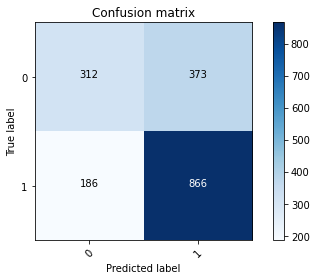

In [26]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

labels = [0, 1]
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Testing

In [27]:
test_data["clean_text"] = test_data.text.apply(lambda x: clean_text(x))
test_data.head()

,Unnamed: 0,text_id,text,clean_text
0,0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,west bengal doctor crisis protesting doctors a...
1,1,hasoc_en_416,68.5 million people have been forced to leave ...,million people have been forced to leave their...
2,2,hasoc_en_207,"You came, you saw .... we will look after the ...",you came you saw we will look after the fort g...
3,3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,we ll get brexit delivered by october st help ...
4,4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,fuck you go back to the dark ages you cow rape...


In [28]:
tokenizer.fit_on_texts(test_data["clean_text"])

sequences = tokenizer.texts_to_sequences(test_data["clean_text"])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 16351 unique tokens.


In [0]:
predictions = list(map(get_indices, lstm.predict(data)))
pd.DataFrame({"labels": predictions}).to_csv("/gdrive/My Drive/Dataset/AICrowd/HateSpeechDetection/submission.csv", index=True)